In [1]:
from glob import glob
import os
from itertools import combinations

import grapheme
from collatex import *
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases

In [2]:
sigles = [os.path.basename(fn).replace('xml_', '').replace('.xml', '') for fn in glob('../data/xml_martijn/*.xml')]
sigles = sorted(sigles)
sigles

['A',
 'Ant',
 'B',
 'BR',
 'C',
 'D',
 'D2',
 'E',
 'F',
 'G',
 'Ge',
 'K',
 'L',
 'O',
 'W',
 'Y',
 'Z']

In [3]:
#sigles = 'A', 'B', 'C', 'D'
#sigles = 'A','Ant','B', 'BR', 'C','D', 'D2','E', 'F', 'G', 'Ge', 'K', 'L', 'O', 'W', 'Y', 'Z'

In [4]:
from lxml import etree
from re import sub #re — Regular expression operations #
import xml.etree.ElementTree as ET
import string


NSMAP = {'MVN': 'http://www.tei-c.org/ns/1.0'}
removes = ('teiHeader', 'fw', 'supplied', 'abbr') 
removes_expan_false = ('teiHeader', 'fw', 'supplied', 'ex', 'expan')

def extract_lines(xml_file, expan = True,
                  punct = True, lower = True,
                  sep_abbr = True):
    lines = {}
    tree = etree.parse(xml_file)
    
    
    if expan:
        #delete all elements with the provided tag names from a tree or subtree
        #will also remove the tail text unless explicitly set the with_tail keyword argument option to False
        etree.strip_elements(tree, ("{"+ NSMAP["MVN"]+ "}" + s for s in removes), with_tail=False) 
    else: 
        etree.strip_elements(tree, ("{"+ NSMAP["MVN"]+ "}" + s for s in removes_expan_false), with_tail=False)
        
    for element in tree.iterfind('.//'+"{"+ NSMAP["MVN"]+ "}"+'l'): #add namespace because otherwise it won't find the element gap
        if(element.find('.//'+"{"+ NSMAP["MVN"]+ "}"+'gap')) is not None:
            element.getparent().remove(element)
            
    chars = {'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 
             'k', 'l','m', 'n', 'o', 'p', 'q', 'r', 's', 't', 
             'u', 'v', 'w', 'x', 'y', 'z'}
            
    context = etree.iterwalk(tree, events=("start", "end")) #a tree walker generates events from an existing tree. 'Start' and 'end' represent opening and closing elements
    #u prefix indicates Unicode
    text = u"" 
    #this will be the key in the dictionary of lines {}
    k = '' 
    for action, node in context:
        #remove ns for easier access
        #tag_only bevat de tags op een knooppunt
        #.tag selects all child elements with the given tag. A tag is a string identifying what kind of data this element represents (the element type, in other words).
        #.replace removes ns www.tei...
        
        tag_only = node.tag.replace("{http://www.tei-c.org/ns/1.0}","") 
            
        #node.attrib: XML elements have attributes 
        #attrib is a dictionary containing the element’s attributes. 
        if 'n' in node.attrib and tag_only == 'text': 
            title = node.attrib['n'] #for example Eerste Martijn
        
        if 'n' in node.attrib and tag_only == "l":                
            k = title + '-' + node.attrib['n'] #for example 001, 002, 003...
  
        # if a new pb (standalone element) is processed:
        if action == 'start' and tag_only == 'text': 
            continue
            
        # if new lb (standalone) is processed:
        elif action == 'start' and tag_only == 'lb':
            continue

        # list elements which you want to iterate through. this is not really neccessary.
        elif tag_only in ("group","text","MVN","body","cb","p"):
            continue

        # for all other elements, distinguish between the start-event of the processing and
        # and the end-event. Attach the tail AFTER the child nodes were processed (= end-event) 

        elif action == 'start':
            #comment the following two lines out to not get the element markers
            #f.write(f"[{tag_only}]") 
            #text += f"[{tag_only}]"

            ############################################################################
            ########## filter out special characters, bars,                   ##########
            ########## superscript, or specific tags.                         ##########
            ############################################################################
                    
            
            #if a special glyph is present, encode it accordingly
            if tag_only == 'g':
                if sep_abbr:
                    if node.attrib['ref'] == '#bar': # ā, ē, ī, ō, ū, n̄ etc.
                        text += u'\u005f'

                    elif node.attrib['ref'] == '#apomod': # ʼ
                        text += u'\u02bc'

                    elif node.attrib['ref'] == '#usmod': # ꝰ
                        text += u'\ua770'

                    elif node.attrib['ref'] == '#condes': # ꝯ
                        text += u'\ua76f'

                    elif node.attrib['ref'] == '#para': # ¶
                        text += u'\xb6'

                    elif node.attrib['ref'] == '#etfin': # ꝫ
                        text += u'\ua76b'

                    elif node.attrib['ref'] == '#pbardes': # ꝑ
                        text += '\ua751'

                    elif node.attrib['ref'] == '#pbardes': # ꝕ
                        text += u'\ua755'

                    elif node.attrib['ref'] == '#pflour': # ꝓ
                        text += u'\ua753'

                    else:
                        text += str(node.attrib['ref']) # get the actual ref if there still are any left
                    
                else:
                    if node.attrib['ref'] == '#bar': # ā, ē, ī, ō, ū, n̄ etc.
                        text += u'\u0304'

                    elif node.attrib['ref'] == '#apomod': # ʼ
                        text += u'\u02bc'

                    elif node.attrib['ref'] == '#usmod': # ꝰ
                        text += u'\ua770'

                    elif node.attrib['ref'] == '#condes': # ꝯ
                        text += u'\ua76f'

                    elif node.attrib['ref'] == '#para': # ¶
                        text += u'\xb6'

                    elif node.attrib['ref'] == '#etfin': # ꝫ
                        text += u'\ua76b'

                    elif node.attrib['ref'] == '#pbardes': # ꝑ
                        text += u'\ua751'

                    elif node.attrib['ref'] == '#pbardes': # ꝕ
                        text += u'\ua755'

                    elif node.attrib['ref'] == '#pflour': # ꝓ
                        text += u'\ua753'

                    else:
                        node.attrib['ref']
                        text += str(node.attrib['ref']) # get the actual ref if there still are any left

            # encode superscript letters
            superscript_dict = {'a':'ᵃ', 'b':'ᵇ', 'c':'ᶜ', 'd':'ᵈ', 'e':'ᵉ', 'f':'ᶠ',
                               'g':'ᵍ', 'h':'ʰ', 'i':'ᶦ', 'j':'ʲ', 'k':'ᵏ', 'l':'ˡ', 
                                'm':'ᵐ', 'n':'ⁿ', 'o':'ᵒ', 'p':'ᵖ', 'r':'ʳ', 's':'ˢ', 
                                't':'ᵗ', 'u':'ᵘ', 'v':'ᵛ', 'w':'ʷ', 'x':'ˣ', 'y': 'ʸ', 'z': 'ᶻ'}

            if tag_only == 'hi' and 'rend' in node.attrib and node.attrib['rend'] == 'superscript': #rend(ition) supplies information about the appearance of an element
                if node.text in superscript_dict:
                    text += str(superscript_dict[node.text]).strip()

            # encode punctuation marks
            elif tag_only == 'pc':
                text += str(node.text).strip()

            # encode roman numerals
            elif tag_only == 'num':
                if node.text:
                    text += str('.'+node.text+'.').strip()

            # if there is still a node with text in it
            elif (node.text):
                text += node.text        

        # after the child elements
        elif action == 'end':
            #if there is a tail
            #the tail attribute holds the text between the element’s end tag and the next tag, or None
            if (node.tail and node.tail not in "\t"): #if the tail is not yet in the text 
                #comment the following two lines out to not get the tail marker
                #text += "[tail]"
                #f.write("[tail]")
                #append to text-concatenation
                text += str(node.tail)
        if tag_only == 'lb':
            if k:
                text = sub(r'\n', '', text) #when an "r" prefix is present, a character following a backslash is included in the string/all backslashes are left in string. 
                if not punct:
                    text = text.translate(str.maketrans('', '', string.punctuation)) #the value of the keys k is the text 
                if lower: 
                    text = text.lower()
                   
                    #text = text[::-1]
                  
                lines[k] = text #the value of the keys k is the text 
                text = ''                    
    lines = {k:v for k, v in lines.items() if v.strip()} #if a line with a gap is removed, remove empty key       
    
    return lines

# nog lowercasen (flag) en interpunctie weghalen
d = extract_lines(f'../data/xml_martijn/xml_{sigles[0]}.xml', expan = False, punct = False, lower = True)
#print(d)

In [5]:
mss = {}

for sigle in tqdm(sigles):
    mss[sigle] = extract_lines(f'../data/xml_martijn/xml_{sigle}.xml',
                               expan = False, punct = False, lower = True,
                               sep_abbr = True)
print(mss['A'])

100%|██████████| 17/17 [00:00<00:00, 29.56it/s]

{'Eerste Martijn-001': 'vvaphene mʼtin hoe salt gaen', 'Eerste Martijn-002': 'sal die wʼelt hiet laghe stae', 'Eerste Martijn-003': 'in dus crancke loue', 'Eerste Martijn-004': 'so moet vᵒuwe vʼeere saen', 'Eerste Martijn-005': 'sondʼ twifel ende waen', 'Eerste Martijn-006': 'rumen heʼen houe', 'Eerste Martijn-007': 'ic zie de valsche wel ontfaen', 'Eerste Martijn-008': 'die de heʼen cone dwaen', 'Eerste Martijn-009': 'en plucke vande stoue', 'Eerste Martijn-010': 'en ic zie de rechte slaen', 'Eerste Martijn-011': 'beede bespotte en beuaen', 'Eerste Martijn-012': 'alse die meese in de cloue', 'Eerste Martijn-013': 'rechts offene god vʼscroue', 'Eerste Martijn-014': 'hoe langhe sal ghedoghe dit', 'Eerste Martijn-015': 'god die alle dinc besit', 'Eerste Martijn-016': 'in sine heerscapie', 'Eerste Martijn-017': 'dat die goede vleeuwet en bit', 'Eerste Martijn-018': 'en he ne doech no dat no dit', 'Eerste Martijn-019': 'dat hi hiet ghedie', 'Eerste Martijn-020': 'al varet inde helsche pit'

In [6]:
print(mss.keys())

dict_keys(['A', 'Ant', 'B', 'BR', 'C', 'D', 'D2', 'E', 'F', 'G', 'Ge', 'K', 'L', 'O', 'W', 'Y', 'Z'])


In [7]:
# from: https://gist.github.com/slowkow/06c6dba9180d013dfd82bec217d22eb5

def align_nw(x, y, match = 1, mismatch = 1, gap = 1):
    x = list(grapheme.graphemes(x))
    y = list(grapheme.graphemes(y))
    
    nx = len(x)
    ny = len(y)
    # Optimal score at each possible pair of characters.
    F = np.zeros((nx + 1, ny + 1))
    F[:,0] = np.linspace(0, -nx, nx + 1)
    F[0,:] = np.linspace(0, -ny, ny + 1)
    # Pointers to trace through an optimal aligment.
    P = np.zeros((nx + 1, ny + 1))
    P[:,0] = 3
    P[0,:] = 4
    # Temporary scores.
    t = np.zeros(3)
    for i in range(nx):
        for j in range(ny):
            if x[i] == y[j]:
                t[0] = F[i,j] + match
            else:
                t[0] = F[i,j] - mismatch
            t[1] = F[i,j+1] - gap
            t[2] = F[i+1,j] - gap
            tmax = np.max(t)
            F[i+1,j+1] = tmax
            if t[0] == tmax:
                P[i+1,j+1] += 2
            if t[1] == tmax:
                P[i+1,j+1] += 3
            if t[2] == tmax:
                P[i+1,j+1] += 4
    # Trace through an optimal alignment.
    i = nx
    j = ny
    rx = []
    ry = []
    while i > 0 or j > 0:
        if P[i,j] in [2, 5, 6, 9]:
            rx.append(x[i-1])
            ry.append(y[j-1])
            i -= 1
            j -= 1
        elif P[i,j] in [3, 5, 7, 9]:
            rx.append(x[i-1])
            ry.append('-')
            i -= 1
        elif P[i,j] in [4, 6, 7, 9]:
            rx.append('-')
            ry.append(y[j-1])
            j -= 1
    # Reverse the strings.
    rx = rx[::-1]
    ry = ry[::-1]
    return rx, ry

a, b = align_nw('en̄ niet sceldē dē heʼe', 'en̄ niet scelden dē here')
print(a)
print(b)

['e', 'n̄', ' ', 'n', 'i', 'e', 't', ' ', 's', 'c', 'e', 'l', 'd', '-', 'ē', ' ', 'd', 'ē', ' ', 'h', 'e', 'ʼ', 'e']
['e', 'n̄', ' ', 'n', 'i', 'e', 't', ' ', 's', 'c', 'e', 'l', 'd', 'e', 'n', ' ', 'd', 'ē', ' ', 'h', 'e', 'r', 'e']


In [8]:
def align_collatex(l1, l2):
    A = [{'t': c, 'n': c} for c in grapheme.graphemes(l1)]
    B = [{'t': c, 'n': c} for c in grapheme.graphemes(l2)]
    json_form = {'witnesses': [{'id': 'A', 'tokens': A},
                               {'id': 'B', 'tokens': B}]}

    A, B = str(collate(json_form, output='table')).split('\n')[1:3]

    A = A.replace('| A | ', '').replace(' | ', '').replace(' |', '')
    B = B.replace('| B | ', '').replace(' | ', '').replace(' |', '')
    
    A = list(grapheme.graphemes(A))
    B = list(grapheme.graphemes(B))
    
    return A, B

a, b = align_collatex('en̄ niet sceldē dē heʼe', 'en̄ niet scelden dē here')
print(a)
print(b)

['e', 'n̄', ' ', 'n', 'i', 'e', 't', ' ', 's', 'c', 'e', 'l', 'd', 'ē', ' ', ' ', 'd', 'ē', ' ', 'h', 'e', 'ʼ', 'e']
['e', 'n̄', ' ', 'n', 'i', 'e', 't', ' ', 's', 'c', 'e', 'l', 'd', 'e', 'n', ' ', 'd', 'ē', ' ', 'h', 'e', 'r', 'e']


In [9]:
def get_distances(mss, method='NW'):
    distances = []
    for ms1, ms2 in tqdm(list(combinations(mss.keys(), 2))):
        common_idxs = set(mss[ms1].keys()).intersection(set(mss[ms2].keys()))
        for idx in common_idxs:
            line1, line2 = mss[ms1][idx], mss[ms2][idx]
            if method == 'NW':
                rx, ry = align_nw(line1, line2)
            elif method == 'CollateX':
                rx, ry = align_collatex(line1, line2)
            if len(rx) != len(ry):
                print(line1, line2)
            length = len(rx)
            for idx, (a, b) in enumerate(zip(rx, ry)):
                if a != b:
                    distances.append((ms1, ms2, idx/length, 1, a, b))
                else:
                    distances.append((ms1, ms2, idx/length, 0, a, b))
    return pd.DataFrame(distances, columns=('ms1', 'ms2', 'position', 'mismatch', 'char1', 'char2'))

In [10]:
nw_mismatches = get_distances(mss, method='NW')
cx_mismatches = get_distances(mss, method='CollateX')
nw_mismatches.sample(5)
cx_mismatches.sample(5)

100%|██████████| 136/136 [08:20<00:00,  3.68s/it]


,ms1,ms2,position,mismatch,char1,char2
1362693,G,L,0.423077,0,n,n
1264667,F,L,0.125000,0,r,r
38870,A,B,0.652174,0,e,e
901470,C,O,0.096774,0,s,s
116594,A,D,0.100000,0,s,s


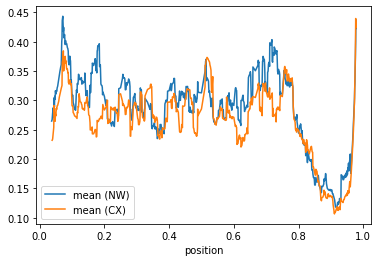

In [11]:
nw_rolling_window = nw_mismatches.groupby('position')['mismatch'].mean().rolling(window=20).mean()
cx_rolling_window = cx_mismatches.groupby('position')['mismatch'].mean().rolling(window=20).mean()

ax = nw_rolling_window.plot(label="mean (NW)")
cx_rolling_window.plot(label="mean (CX)", ax=ax)

plt.legend()

In [13]:
#checken of de resultaten statistisch significant zijn en dat is zo!
#mismatches_end = mismatches[mismatches['position'] > .75]
#mismatches_beginning = mismatches[mismatches['position'] <= .75]
#from scipy.stats import mannwhitneyu
#mannwhitneyu(mismatches_end['mismatch'], mismatches_beginning['mismatch'], alternative='less')

## Clustermap

In [14]:
for ms in mss:
    print(ms, len(mss[ms]))

A 1761
Ant 0
B 1820
BR 568
C 1469
D 1821
D2 136
E 275
F 1821
G 1772
Ge 70
K 66
L 407
O 1823
W 506
Y 272
Z 528


In [15]:
sigles = sorted(mss.keys())
print(sigles)
sigles = [s for s in sigles if len(mss[s]) >= 506]
print(sigles)

['A', 'Ant', 'B', 'BR', 'C', 'D', 'D2', 'E', 'F', 'G', 'Ge', 'K', 'L', 'O', 'W', 'Y', 'Z']
['A', 'B', 'BR', 'C', 'D', 'F', 'G', 'O', 'W', 'Z']


In [16]:
df_clust = np.zeros((len(sigles), len(sigles)))
print(df_clust.shape)

(10, 10)


In [17]:
for s1, s2 in combinations(sigles, 2):
    print(s1, s2)
    d = nw_mismatches[(nw_mismatches['ms1'] == s1) & (nw_mismatches['ms2'] == s2)]['mismatch'].mean()
    df_clust[sigles.index(s1), sigles.index(s2)] = d
    df_clust[sigles.index(s2), sigles.index(s1)] = d

A B
A BR
A C
A D
A F
A G
A O
A W
A Z
B BR
B C
B D
B F
B G
B O
B W
B Z
BR C
BR D
BR F
BR G
BR O
BR W
BR Z
C D
C F
C G
C O
C W
C Z
D F
D G
D O
D W
D Z
F G
F O
F W
F Z
G O
G W
G Z
O W
O Z
W Z


In [18]:
df_clust = pd.DataFrame(df_clust, columns=sigles, index=sigles)
df_clust

,A,B,BR,C,D,F,G,O,W,Z
A,0.000000,0.173195,0.194305,0.184274,0.217338,0.187612,0.266794,0.200272,0.210255,0.252259
B,0.173195,0.000000,0.222309,0.196430,0.211765,0.201606,0.279963,0.204174,0.224327,0.264546
BR,0.194305,0.222309,0.000000,0.203407,0.201515,0.146184,0.250885,0.224740,0.197614,0.197976
C,0.184274,0.196430,0.203407,0.000000,0.189961,0.181911,0.298349,0.192452,0.237697,0.282516
D,0.217338,0.211765,0.201515,0.189961,0.000000,0.168470,0.310365,0.196907,0.259175,0.283570
F,0.187612,0.201606,0.146184,0.181911,0.168470,0.000000,0.276135,0.181669,0.219001,0.235806
G,0.266794,0.279963,0.250885,0.298349,0.310365,0.276135,0.000000,0.304490,0.136525,0.266939
O,0.200272,0.204174,0.224740,0.192452,0.196907,0.181669,0.304490,0.000000,0.243588,0.291811
W,0.210255,0.224327,0.197614,0.237697,0.259175,0.219001,0.136525,0.243588,0.000000,0.270384
Z,0.252259,0.264546,0.197976,0.282516,0.283570,0.235806,0.266939,0.291811,0.270384,0.000000


/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/seaborn/matrix.py:620: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


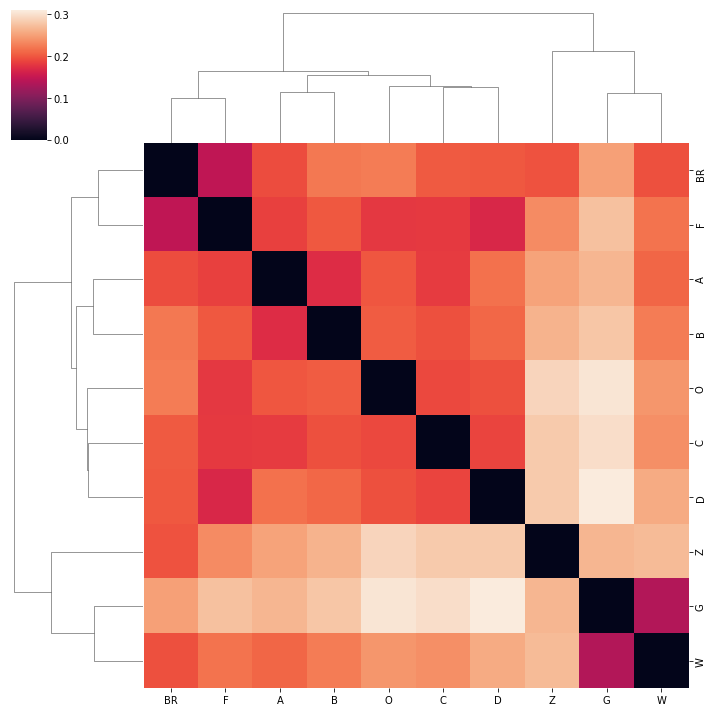

In [19]:
import seaborn as sb
sb.clustermap(df_clust, method='ward');

## Abbreviation density

In [20]:
abbr_density = []

for sigle in sigles:
    abbr = extract_lines(f'../data/xml_martijn/xml_{sigle}.xml', expan = False, punct = False, lower = True)
    expan = extract_lines(f'../data/xml_martijn/xml_{sigle}.xml', expan = True, punct = False, lower = True)
    
    line_idxs = sorted(abbr.keys())
    abbr_lens = np.array([len(abbr[line]) for line in line_idxs])
    expan_lens = np.array([len(expan[line]) for line in line_idxs])
    
    diffs = pd.Series(expan_lens - abbr_lens)
    ratios = pd.Series(abbr_lens / expan_lens)
    abbr_density.append((sigle, diffs.mean(), diffs.std(), ratios.mean(), ratios.std()))

dens = pd.DataFrame(abbr_density, columns=['sigle', 'diff-mean', 'diff-std', 'ratio-mean', 'ratio-std'])
dens.dropna(inplace=True)
dens.set_index('sigle', inplace=True)

In [21]:
dens

,diff-mean,diff-std,ratio-mean,ratio-std
sigle,,,,
A,1.281658,1.267670,0.954306,0.043616
B,1.113187,1.178113,0.959807,0.041200
BR,1.207746,1.148180,0.955133,0.040983
C,0.402314,0.824205,0.985216,0.030835
D,0.138386,0.516288,0.995722,0.015790
F,0.600769,0.958123,0.979705,0.031948
G,3.004515,1.701291,0.892987,0.057011
O,0.558420,0.905989,0.981547,0.029366
W,1.944664,1.754457,0.931749,0.060387


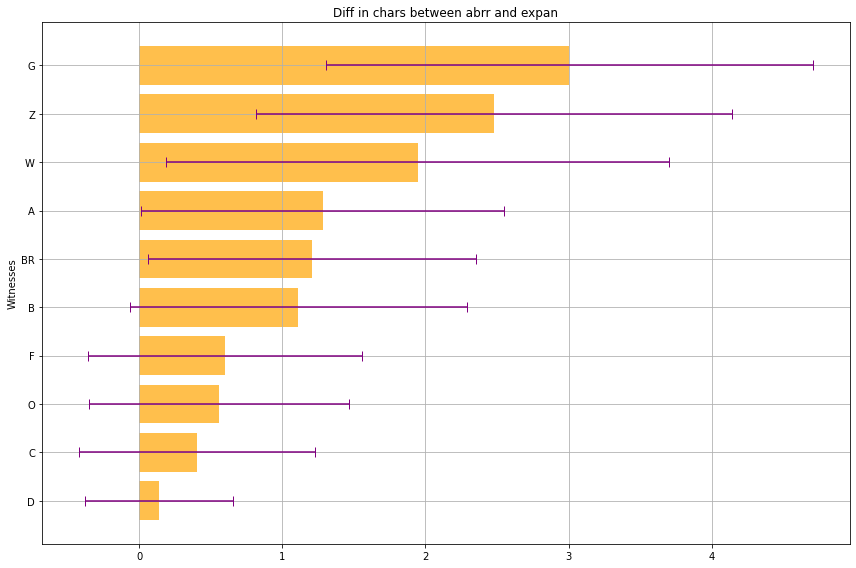

In [22]:
dens.sort_values(by='diff-mean', inplace=True)
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(range(len(dens.index)), dens['diff-mean'],
       xerr=dens['diff-std'],
       color='orange',
       align='center',
       alpha=0.7,
       ecolor='purple',
       capsize=5)
ax.set_ylabel('Witnesses')
ax.set_yticks(range(len(dens.index)))
ax.set_yticklabels(dens.index)
ax.set_title('Diff in chars between abrr and expan')
ax.xaxis.grid(True)
ax.yaxis.grid(True)
plt.tight_layout()

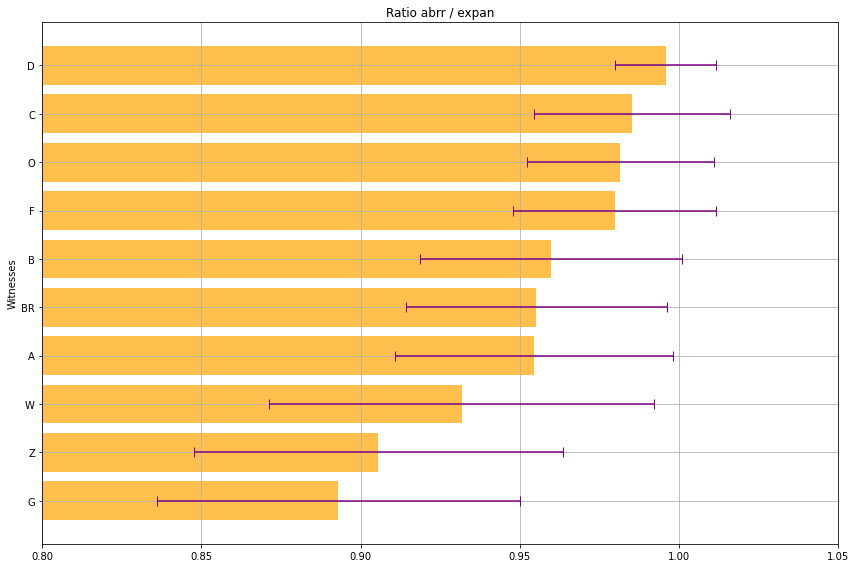

In [23]:
dens.sort_values(by='ratio-mean', inplace=True)
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(range(len(dens.index)), dens['ratio-mean'],
       xerr=dens['ratio-std'],
       color='orange',
       align='center',
       alpha=0.7,
       ecolor='purple',
       capsize=5)
ax.set_ylabel('Witnesses')
ax.set_yticks(range(len(dens.index)))
ax.set_yticklabels(dens.index)
ax.set_title('Ratio abrr / expan')
plt.xlim(0.8, 1.05)
ax.xaxis.grid(True)
ax.yaxis.grid(True)
plt.tight_layout()

## Pixelplot

In [24]:
all_lines = set()
for ms in mss:
    all_lines.update(mss[ms].keys())

def repl(n):
    n = n.replace('Eerste Martijn', '1')
    n = n.replace('Tweede Martijn', '2')
    n = n.replace('Derde Martijn', '3')
    n = n.replace('Vierde Martijn', '4')
    return n

all_lines = [repl(l) for l in all_lines]
all_lines = sorted(all_lines)
ms_names = sorted(mss.keys())
grid = np.ones((len(all_lines), len(mss.keys())))
grid.shape

for ms in mss:
    for line in mss[ms]:
        grid[all_lines.index(repl(line)), ms_names.index(ms)] = 0

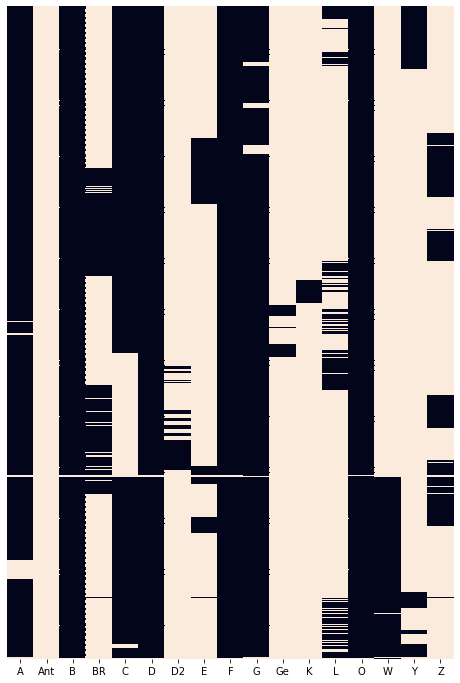

In [25]:
fig, ax = plt.subplots(figsize=(8, 12))
sb.heatmap(grid, xticklabels=ms_names, yticklabels=False, ax=ax, cbar=False);